# Mount the cameras in a convergent configuration:
   - Set up the dual cameras in a configuration where the optical axes converge towards a common point. This convergent setup is essential for capturing images that can be used for phototriangulation.
   - Website: N/A (Instructions only)

# Camera calibration:
   - Perform camera calibration to determine intrinsic camera parameters such as focal length, principal point, and lens distortion coefficients. This step ensures accurate image measurements and helps in subsequent processing steps.
   - OpenCV-Python Tutorials: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html


In [4]:
import numpy as np
import cv2 as cv
import glob
import os

'''
Using camera calibration tutorial avaiable in OpenCV documentation. Link: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html
'''
def rectify(n):
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((8*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob(f'C://Users//joao.kreitlon//Documents//IME//2023.1//Foto_digital//Sist_dual//cam_{n}_t//*.png')

    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (8,6), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            # Draw and display the corners
            cv.drawChessboardCorners(img, (8,6), corners2, ret)
            cv.imshow('img', img)
            cv.waitKey(500)
            
    cv.destroyAllWindows()

    #Calibrating the camera:
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    print(f'\n \n--------------------   CAMERA {n}   --------------------\n')
    print(f'The camera {n} Matrix is the following:\n', mtx)
    print('\nThe distortion coefficients are the following:\n', dist, '\n\n k1,k2,p1,p2,k3, in that order')


    r_list = [list() for _ in range(3)]
    t_list =[list() for _ in range(3)]

    for i in range (len(rvecs)):
        for j in range(len(r_list)):
            r_list[j].append(rvecs[i][j])
            t_list[j].append(tvecs[i][j])

    x0, y0, z0 = t_list
    phi, omega, kappa = r_list


    test = glob.glob(f'C://Users//joao.kreitlon//Documents//IME//2023.1//Foto_digital//Sist_dual//test_{n}_t//*.png')
   

    cont = 0

    # rect_list = []

    for fname in test:
        img = cv.imread(fname)
        h,  w = img.shape[:2]
        newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
        
        # undistort
        dst = cv.undistort(img, mtx, dist, None, newcameramtx)
        # crop the image
        x, y, w, h = roi
        dst = dst[y:y+h, x:x+w]
        name = f'rectif_{n}//ret_{cont}.png'
        # print(name)
        cv.imwrite(name, dst)
        
        cont += 1

    rot = [omega, phi, kappa]
    trs = [x0, y0, z0]    

    return newcameramtx, dist, trs, rot

cam_1, cam_2 = rectify(1), rectify(2)


 
--------------------   CAMERA 1   --------------------

The camera 1 Matrix is the following:
 [[1.18713457e+03 0.00000000e+00 2.52493572e+02]
 [0.00000000e+00 1.18908521e+03 2.07691540e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

The distortion coefficients are the following:
 [[-5.74143956e-01  5.35978896e+00  4.35487764e-03 -2.84546899e-03
  -3.66983700e+01]] 

 k1,k2,p1,p2,k3, in that order

 
--------------------   CAMERA 2   --------------------

The camera 2 Matrix is the following:
 [[1.18550643e+03 0.00000000e+00 3.34217203e+02]
 [0.00000000e+00 1.18728572e+03 2.22837815e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

The distortion coefficients are the following:
 [[-4.28091237e-01  1.73926651e-01  3.21650866e-03 -8.07866340e-04
  -1.56390581e+00]] 

 k1,k2,p1,p2,k3, in that order


# External Orientation Parameters

POE: ($\omega$, $\phi$, $\kappa$, $x$, $y$, $z$)

# Rotation Matrix

$$ R_{xyz} = R_x R_y R_z = 
\begin{bmatrix} 1 & 0 & 0 \\ 0 & \cos{\omega} & -\sin{\omega} \\ 1 & \sin{\omega} & \cos{\omega}  \end{bmatrix} 
\begin{bmatrix} \cos{\phi} & 0 & \sin{\phi} \\ 0 & 1 & 0 \\ -\sin{\phi} & 0 & \cos{\phi}  \end{bmatrix} 
\begin{bmatrix} \cos{\kappa} & -\sin{\kappa} & 0 \\ \sin{\kappa} & \cos{\kappa} & 0 \\ 0 & 0 & 1  \end{bmatrix} 

In [7]:
def sub_photo(cam,n,type):

    l = [sub_array[n][0] for sub_array in cam[type]]

    return l

def rot_mtx(o,p,k):
    
    Ro = np.matrix([[1, 0, 0], [0, np.cos(o),-np.sin(o)], [0, np.sin(o),np.cos(o)]])
      
    Rp = np.matrix([[np.cos(p), 0,-np.sin(p)], [0, 1,0], [np.sin(p), 0, np.cos(p)]])
      
    Rk = np.matrix([[np.cos(k),np.sin(k), 0], [-np.sin(k),np.cos(k), 0], [0, 0, 1]])

    M = Rk@Rp@Ro
    return M



# Estimate system mounting parameters:
   Determine the mounting parameters for the dual camera system. These parameters define the geometric relationship between the cameras, such as the distance between them and their relative orientation.
# Annex A

   $$ r_{C_k}^{C_{ref}}(t)= (R^m_{C_{ref}}(t))^{-1} \left( r_{C_k}^{m}(t) - r_{C_{ref}}^m(t) \right) $$

   $$ R^{C_{ref}}_{C_{k}}(t) = R^m_{C_{ref}}(t)^{-1} \cdot R^m_{C_{k}}(t) $$


In [8]:
for n in range (1):

    print('-'*20, f' IMAGEM {n} ', '-'*20)

    r_m_Cref = np.vstack([sub_photo(cam_1,n,2)]).T
    R_m_Cref = rot_mtx(*sub_photo(cam_1,n,3))

    r_m_Ck = np.vstack([sub_photo(cam_2,n,2)]).T
    R_m_Ck = rot_mtx(*sub_photo(cam_2,n,3))

    # Lever-arm:

    r_Cref_Ck = np.linalg.inv(R_m_Cref)@(r_m_Ck-r_m_Cref) 

    # Boresight:

    R_Cref_Ck = np.linalg.inv(R_m_Cref)@(R_m_Ck) 

    print('-'*20, ' BORESIGHT ', '-'*20)
    print('\n', R_Cref_Ck ,'\n')

    print('-'*20, ' LEVER-ARM ', '-'*20)
    print('\n', r_Cref_Ck ,'\n')

--------------------  IMAGEM 0  --------------------
--------------------  BORESIGHT  --------------------

 [[ 0.99997785  0.00479986 -0.00461003]
 [-0.00526066  0.99437475 -0.10578838]
 [ 0.00407633  0.10581029  0.99437798]] 

--------------------  LEVER-ARM  --------------------

 [[-2.61053542]
 [ 0.01544378]
 [ 0.04410711]] 



# Showing corrected tested images

Image 0 from camera 1


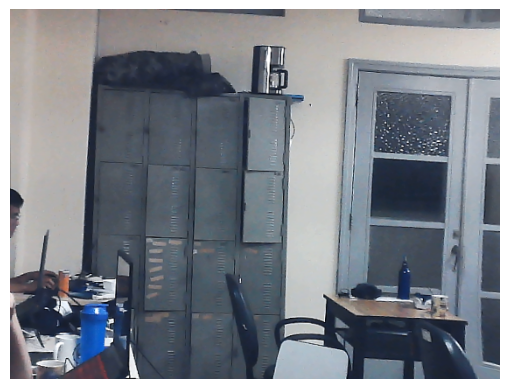

Image 1 from camera 1


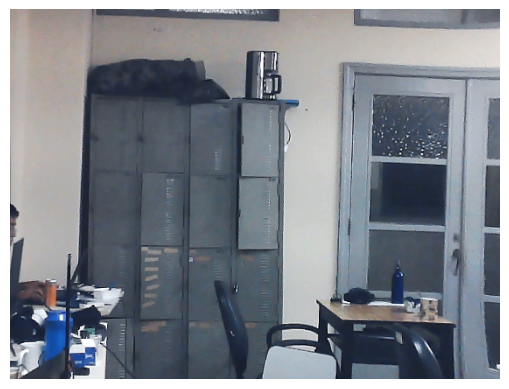

Image 2 from camera 1


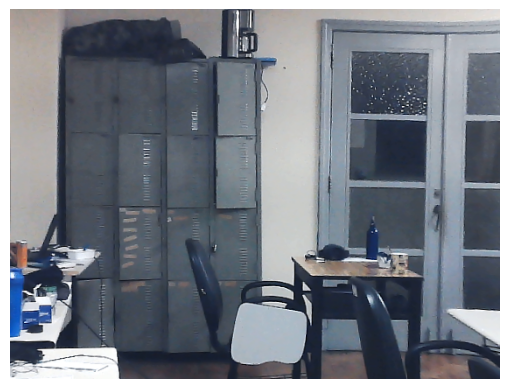

Image 0 from camera 2


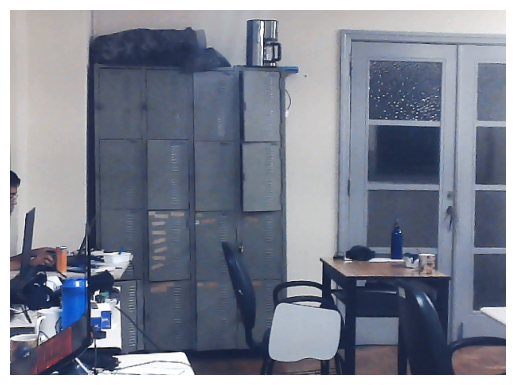

Image 1 from camera 2


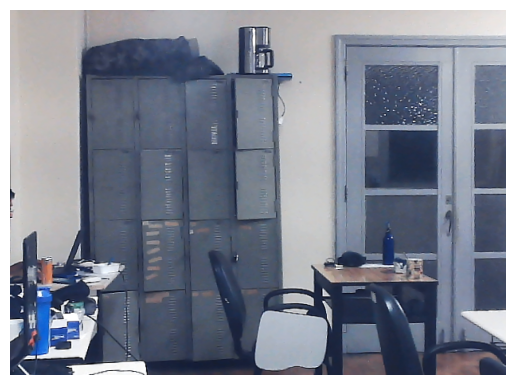

Image 2 from camera 2


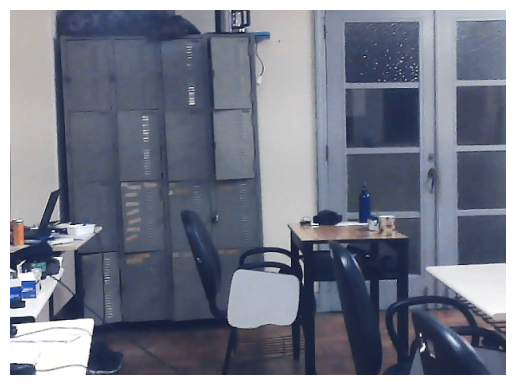

('All images from camera 1 shown', 'All images from camera 2 shown')

In [9]:
import matplotlib.pyplot as plt

def show_img(n):

    folder_path = f"rectif_{n}/*.png"  # Path to the folder containing the images

    image_files = glob.glob(folder_path)

    cont = 0

    for image_file in image_files:
        
        print(f'Image {cont} from camera {n}')

        image = cv.imread(image_file)
        if image is not None:
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
        
        cont += 1
    return f'All images from camera {n} shown'

show_img(1), show_img(2)


# Generate the virtual image

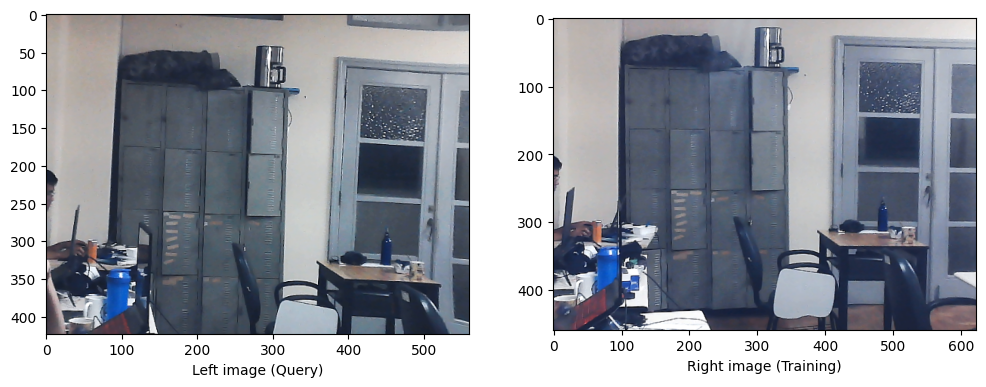

In [72]:
import imageio.v2 as imageio

def graying (n,m):
    image = imageio.imread(f'rectif_{n}\\ret_{m}.png')
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    return image, gray_image

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(12, 8))
ax1.imshow(graying(1,0)[0], cmap="gray")
ax1.set_xlabel("Left image (Query)")

ax2.imshow(graying(2,0)[0], cmap="gray")
ax2.set_xlabel("Right image (Training)")

plt.show()


# Feature matching

-------------------------------------------------------------------------------- IMAGE 0 --------------------------------------------------------------------------------


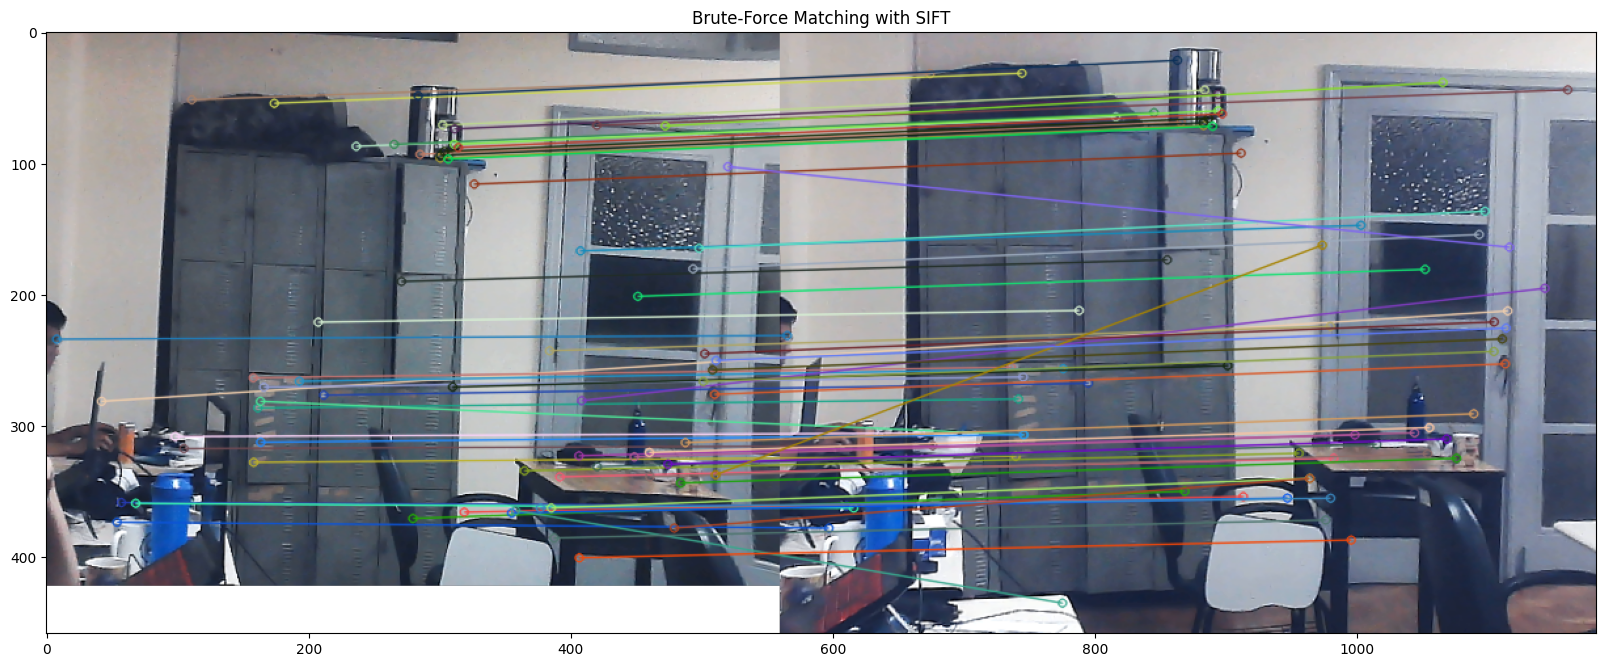

Omega: 0.005491654088040015
Phi: -0.038425828493968604
Kappa: -0.04069670763707797
X0: 0.7175440987005817
Y0: -0.09851175501557762
Z0: -0.6895113491043644
-------------------------------------------------------------------------------- IMAGE 1 --------------------------------------------------------------------------------


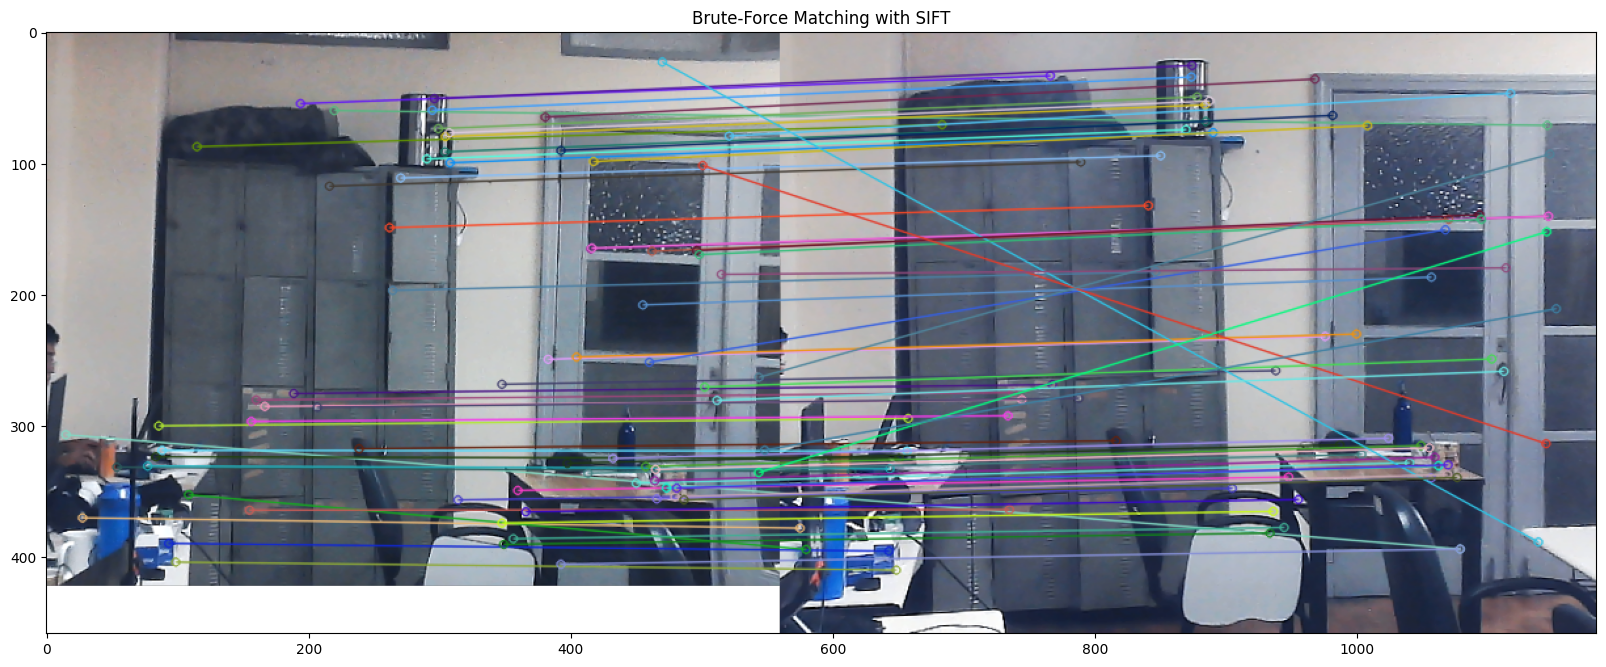

Omega: 0.014405506520700048
Phi: -0.09480783777798309
Kappa: -0.03668995743901184
X0: 0.88945380553081
Y0: 0.013423234057898935
Z0: -0.45682791575623627
-------------------------------------------------------------------------------- IMAGE 2 --------------------------------------------------------------------------------


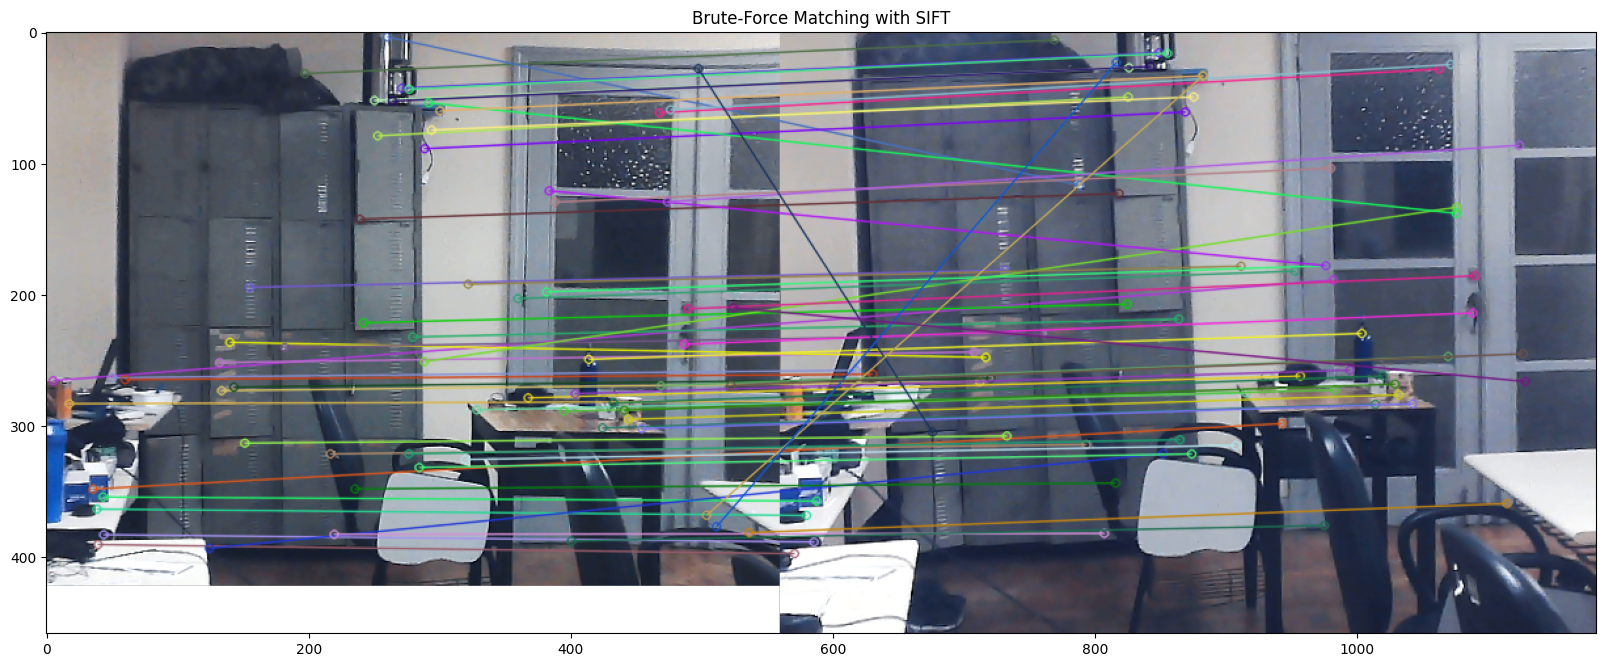

Omega: 0.0015377917504380936
Phi: -0.08345701055145878
Kappa: -0.03630512674471825
X0: 0.8788474546988162
Y0: -0.10949338830247297
Z0: -0.46436876433224483


In [52]:
for i in range (3):

    print ('-'*80, f'IMAGE {i}', '-'*80)

    query_img = graying(1,i)[1]         # queryImage
    training_img = graying(2,i)[1]     # trainImage

    # Initiate SIFT detector and find keypoints and descriptors
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(query_img, None)
    kp2, des2 = sift.detectAndCompute(training_img, None)

    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test to filter out good matches
    good = [[m] for m, n in matches if m.distance < 0.75 * n.distance]

    # Extract corresponding points
    points_img1 = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1, 1, 2)
    points_img2 = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Draw only a subset of matches for visualization
    num_stepped_matches = 2
    indices = np.arange(0, len(good), num_stepped_matches)
    drawn_matches = [good[i] for i in indices]

    # Draw the matches
    img3 = cv.drawMatchesKnn(query_img, kp1, training_img, kp2, drawn_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the image
    plt.figure(figsize=(20, 8))
    plt.title('Brute-Force Matching with SIFT')
    plt.imshow(img3)
    plt.show()

    # Camera calibration matrix for the two images
    camera_matrix_1 = cam_1[0]
    camera_matrix_2 = cam_2[0]

    # Estimate the Essential Matrix
    essential_matrix, _ = cv.findEssentialMat(points_img1, points_img2, camera_matrix_1, method=cv.RANSAC, prob=0.999, threshold=1.0)

    # Recover the Rotation and Translation matrices
    _, rotation_matrix, translation_vector, _ = cv.recoverPose(essential_matrix, points_img1, points_img2, camera_matrix_1)

    # Extract the Euler angles from the Rotation matrix
    rotation_vector, _ = cv.Rodrigues(rotation_matrix)
    omega, phi, kappa = rotation_vector.ravel()

    # Extract the EOP parameters
    X0, Y0, Z0 = translation_vector.ravel()

    # Print the EOP parameters
    print("Omega:", omega)
    print("Phi:", phi)
    print("Kappa:", kappa)
    print("X0:", X0)
    print("Y0:", Y0)
    print("Z0:", Z0)

